In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
from metpy.plots import SkewT
from metpy.units import pandas_dataframe_to_unit_arrays, units
import numpy as np
from siphon.simplewebservice.wyoming import WyomingUpperAir
import metpy.calc as mpcalc

import matplotlib.patches as mpatches

In [10]:
# download data
#https://weather.uwyo.edu/upperair/sounding.html
# 45004 Kings Park HONG KONG

dt = datetime(2022, 5, 11, 12)
adt = dt.strftime("%Y%m%d%H%M%S")

station = '45004'#HONG KONG
#station = '48900' #Ho Chin Min

if station == '45004':
    astn = 'hk'
    
if station == '48900':
    astn = 'hcm'

#read sounding data
data = WyomingUpperAir.request_data(dt, station)

# create a dictionary with metpy
df = pandas_dataframe_to_unit_arrays(data)
print(df.keys())

dict_keys(['pressure', 'height', 'temperature', 'dewpoint', 'direction', 'speed', 'u_wind', 'v_wind', 'station', 'station_number', 'time', 'latitude', 'longitude', 'elevation', 'pw'])


In [11]:
# extract data
p = df['pressure']
#print (p)
T = df['temperature']
Td = df['dewpoint']
u = df['u_wind']
v = df['v_wind']

cape= 224.43331644272493 joule / kilogram, cin=-8.560567596011166 joule / kilogram
lcl_pressure= 989.7900619620389 hectopascal
lfc_pressure= 599.7995623282454 hectopascal


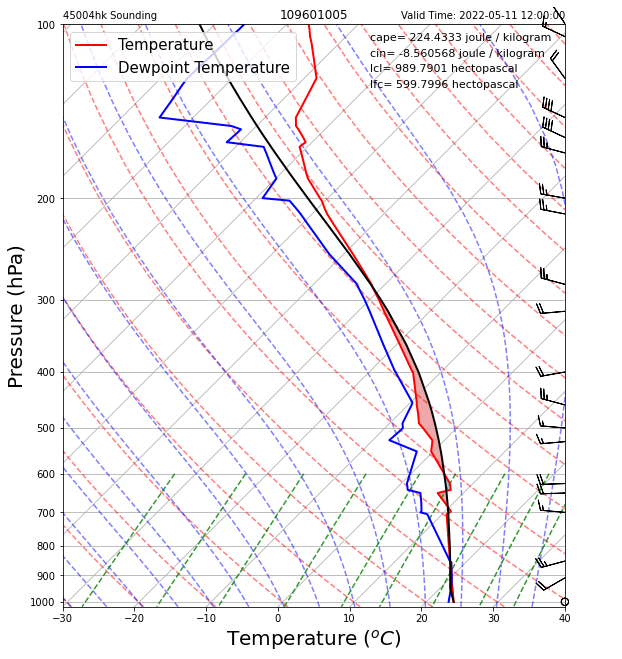

In [12]:
# plotting
fig = plt.figure(figsize=(9,11))

skew = SkewT(fig, rotation=45)

skew.plot(p, T, 'r', lw=2, label='Temperature')
skew.plot(p, Td, 'b', lw=2, label='Dewpoint Temperature')
skew.plot_barbs(p[::3],u[::3],v[::3],y_clip_radius=0.03)

skew.ax.set_xlim(-30,40)
skew.ax.set_ylim(1020,100)

# aLpha= transparency
skew.plot_dry_adiabats(t0=np.arange(233, 533, 10)*units.K, alpha=0.5, color='orange')
skew.plot_moist_adiabats(t0=np.arange(233, 400, 5)*units.K, alpha=0.5, color='green')
skew.plot_mixing_lines()

# Calculate full parcel profile;
prof = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
skew.plot(p, prof, 'k', linewidth=2)

# calculate Convective Availabe Potential Energy: CAPE;
# calculate Convective INhibition: CIN
cape, cin=mpcalc.cape_cin(p, T, Td, prof, which_lfc='bottom', which_el='top')
print (f'cape= {cape}, cin={cin}')

#should areas of CAPE and CIN;
skew.shade_cin(p, T, prof, Td)
skew.shade_cape(p, T, prof)

# Lifted Condensation Level; LCL;
# Level of Free Convection; LFC;
lcl_pressure, lcl_temperature= mpcalc.lcl(p[0], T[0], Td[0])
print (f'lcl_pressure= {lcl_pressure}')

lfc_pressure, lfc_temperature=mpcalc.lfc(p, T, Td, parcel_temperature_profile=prof)
print (f'lfc_pressure= {lfc_pressure}')

plt.title('{} Sounding'.format(station+astn), fontsize=10, loc='left')
plt.title('Valid Time: {}'.format(dt), fontsize=10, loc='right')
plt.xlabel("Temperature ($^oC$)", fontsize=20)
plt.ylabel("Pressure (hPa)", fontsize=20)

plt.legend(loc='upper left', fontsize=15)

#plt.legend(['T cape= {:.7}'.format(cape), 'Td cin={:.7}'.format(cin)])
fig.text(0.60, 0.85, 'cape= {:.7}'.format(cape), fontsize=11)
fig.text(0.60, 0.83, 'cin= {:.7}'.format(cin), fontsize=11)
fig.text(0.60, 0.81, 'lcl= {:.7}'.format(lcl_pressure), fontsize=11)
fig.text(0.60, 0.79, 'lfc= {:.7}'.format(lfc_pressure), fontsize=11)
plt.title('109601005', loc='center')
plt.show()

#fig.savefig('ttskewt_hk_20220512.png', dpi=300)
#fig.savefig('ttskewt_hcm_20220512.png', dpi=300)
fig.savefig('ttskewt_{}.png'.format(astn+adt), dpi=300)